In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import wandb
import json
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Building CNN from scratch
class CNN(nn.Module):
    def __init__(self,
                 input_channels=3,
                 num_classes=10,
                 conv_filters=[32, 64, 128, 256, 512],
                 kernel_size=3,
                 activation_fn=nn.ReLU,
                 dense_neurons=256,
                 input_image_size=(224, 224)):
        super(CNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = input_channels

        for out_channels in conv_filters:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
            self.conv_layers.append(conv)
            in_channels = out_channels

        self.activation_fn = activation_fn()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flattened_size = None
        self.dense = None
        self.output = None

        self.dense_neurons = dense_neurons
        self.num_classes = num_classes
        self.input_image_size = input_image_size

    def forward(self, x):
        for i, conv in enumerate(self.conv_layers):
            x = conv(x)
            x = self.activation_fn(x)
            x = self.pool(x)

        x = self.activation_fn(x)
        x = self.pool(x)

        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).shape[1]
            self.dense = nn.Linear(self.flattened_size, self.dense_neurons).to(x.device)
            self.output = nn.Linear(self.dense_neurons, self.num_classes).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.dense(x)
        x = self.activation_fn(x)
        x = self.output(x)
        return x

    def calculate_total_parameters_and_computations(self):
        H, W = self.input_image_size
        C = 3
        total_params = 0
        total_ops = 0

        print("Calculating total parameters and computations:")

        for i, conv in enumerate(self.conv_layers):
            out_channels = conv.out_channels
            k = conv.kernel_size[0]
            params_per_filter = k * k * C + 1
            layer_params = out_channels * params_per_filter
            total_params += layer_params

            ops_per_pixel = k * k * C
            H_out, W_out = H // 2, W // 2
            layer_ops = H_out * W_out * out_channels * ops_per_pixel
            total_ops += layer_ops

            print(f"Layer {i+1}: Params={layer_params}, Ops={layer_ops}")

            H, W = H_out, W_out
            C = out_channels

        H, W = H // 2, W // 2

        f = C * H * W
        dense_params = f * self.dense_neurons + self.dense_neurons
        dense_ops = f * self.dense_neurons

        output_params = self.dense_neurons * self.num_classes + self.num_classes
        output_ops = self.dense_neurons * self.num_classes

        print(f"Dense Layer: Params={dense_params}, Ops={dense_ops}")
        print(f"Output Layer: Params={output_params}, Ops={output_ops}")

        total_params += dense_params + output_params
        total_ops += dense_ops + output_ops

        print(f"Total Parameters: {total_params}, Total Operations: {total_ops}")
        return total_params, total_ops


In [3]:
# Get data and split
def load_data(data_dir, batch_size=64, augment=True):
    print("Preparing data with augmentation:" if augment else "Preparing data without augmentation")
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224) if augment else transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip() if augment else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_data = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform_train)
    val_size = int(0.2 * len(train_data))
    train_size = len(train_data) - val_size
    train_set, val_set = random_split(train_data, [train_size, val_size])

    test_set = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform_test)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)

    print(f"Train size: {train_size}, Val size: {val_size}, Test size: {len(test_set)}")
    return train_loader, val_loader, test_loader

In [4]:
# Save & load checkpoints
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")


def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and optimizer state from checkpoint.
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint.get('epoch', 0)


In [5]:
# Training & Validation
def validate_model(model, val_loader, device):
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    val_acc = 100 * val_correct / val_total
    return val_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, checkpoint_path=None):
    model.to(device)

    # Create checkpoint path using wandb run ID
    run_id = wandb.run.id if wandb.run else "default"
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = checkpoint_path or os.path.join(checkpoint_dir, f"ckpt_{run_id}.pth")

    # Try loading from checkpoint
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        try:
            start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
            print(f"✅ Loaded checkpoint from '{checkpoint_path}', resuming at epoch {start_epoch}.")
        except RuntimeError as e:
            print(f"⚠️  Skipping checkpoint load due to mismatch:\n{e}")
            start_epoch = 0

    # Training loop
    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch+1}/{epochs}:")
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = validate_model(model, val_loader, device)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": total_loss / total,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        print(f"✅ Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Save checkpoint at end of epoch
        save_checkpoint(model, optimizer, epoch + 1, checkpoint_path)
        print(f"💾 Checkpoint saved to {checkpoint_path}")


In [6]:
def get_sweep_config():
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            #'conv_filters': {
            #    'values': [[32, 64, 128, 256, 512], [32]*5, [64]*5, [128, 64, 32, 16, 8]]
            #},
            'conv_filters': {
                'values': [[32, 64, 128, 256, 512], [128, 64, 32, 16, 8]]
            },
            'activation_fn': {
                #'values': ['ReLU', 'GELU', 'SiLU', 'Mish']
                'values': ['ReLU', 'GELU', 'SiLU', 'Mish', 'LeakyReLU']
            },
            'augment': {
                'values': [True, False]
            },
            'batch_norm': {
                'values': [True, False]
            },
            'dropout': {
                'values': [0.2, 0.3]
            },
            'dense_neurons': {
                'values': [128, 256, 512]
            },
            'learning_rate': {
                'values': [0.001, 0.0005]
            },
            'num_epochs': {
                'values': [3, 5, 7]
            },
            'batch_size': {
                'values': [16, 32, 64]
            }
        }
    }
    return sweep_config


def save_sweep_hyperparameters_to_file(config, filename="sweep_hyperparameters.json"):
    """
    Save the hyperparameters and their values to a file after each sweep run.
    This function will append new sweeps to the existing file without overwriting.
    """
    sweep_params = {
        "conv_filters": config['conv_filters'],
        "activation_fn": config['activation_fn'],
        "augment": config['augment'],
        "batch_norm": config['batch_norm'],
        "dropout": config['dropout'],
        "dense_neurons": config['dense_neurons'],
        "learning_rate": config['learning_rate'],
        "num_epochs": config['num_epochs'],
        "batch_size": config['batch_size'],
        "sweep_run_id": wandb.run.id  # Add a unique sweep run ID to each entry
    }

    # Check if file exists, if so, append to it; if not, create a new file
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            all_sweeps = json.load(f)
    else:
        all_sweeps = []

    all_sweeps.append(sweep_params)

    with open(filename, 'w') as f:
        json.dump(all_sweeps, f, indent=4)
    print(f"Hyperparameters saved to {filename}")


def run_sweep(train_loader, val_loader, test_loader):
    wandb.init(
        project="DA6401_DL_ASSIGNMENT_02_PART_A",
        entity="subikksha-indian-institute-of-technology-madras"
    )

    config = wandb.config

    run_name = f"filters_{'_'.join(map(str, config.conv_filters))}_act_{config.activation_fn}_drop_{config.dropout}_lr_{config.learning_rate}_bn_{config.batch_norm}"
    wandb.run.name = run_name

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    save_sweep_hyperparameters_to_file(config)

    model = CNN(
        conv_filters=config.conv_filters,
        activation_fn=getattr(nn, config.activation_fn),
        dense_neurons=config.dense_neurons
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=config.num_epochs, device=device)

    final_val_acc = validate_model(model, val_loader, device=device)
    wandb.log({"final_val_acc": final_val_acc})

    wandb.finish()



In [7]:
wandb.login(key="7ea09f7c4132c66373b03708516876ea8ecc67cc")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: subikksha (subikksha-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
PROJECT_NAME = "DA6401_DL_ASSIGNMENT_02_PART_A"
ENTITY = "subikksha-indian-institute-of-technology-madras"

In [9]:
from google.colab import drive
drive.mount('/content/drive')
SAMPLE_SIZE = 0.30
os.makedirs('/content/drive/MyDrive/checkpoints', exist_ok=True)

Mounted at /content/drive


In [11]:
data_dir = '/content/drive/MyDrive/DL_Data/nature_12K/inaturalist_12K'
train_loader, val_loader, test_loader = load_data(data_dir, batch_size=64, augment=True)

Preparing data with augmentation:
Train size: 8008, Val size: 2001, Test size: 2000


In [11]:
def sweep_wrapper():
    run_sweep(train_loader, val_loader, test_loader)


In [14]:
# Sweep configuration
sweep_config = get_sweep_config()

# Start sweep
#sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME, entity=ENTITY)
sweep_id = "subikksha-indian-institute-of-technology-madras/DA6401_DL_ASSIGNMENT_02_PART_A/vnqurpmm"
wandb.agent(sweep_id, function=sweep_wrapper, count=2)  # Number of sweep trials

wandb: Agent Starting Run: dcqstzti with config:
wandb: 	activation_fn: ReLU
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 16
wandb: 	conv_filters: [32, 64, 128, 256, 512]
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	learning_rate: 0.0005
wandb: 	num_epochs: 5


Using device: cpu
Hyperparameters saved to sweep_hyperparameters.json

Epoch 1/5:


Validating: 100%|██████████| 32/32 [03:38<00:00,  6.82s/it]


✅ Train Acc: 12.89% | Val Acc: 16.39%
Checkpoint saved at epoch 1.
💾 Checkpoint saved to checkpoints/ckpt_dcqstzti.pth

Epoch 2/5:


Validating: 100%|██████████| 32/32 [03:26<00:00,  6.46s/it]


✅ Train Acc: 18.89% | Val Acc: 17.24%
Checkpoint saved at epoch 2.
💾 Checkpoint saved to checkpoints/ckpt_dcqstzti.pth

Epoch 3/5:


Validating: 100%|██████████| 32/32 [03:22<00:00,  6.34s/it]


✅ Train Acc: 20.39% | Val Acc: 21.49%
Checkpoint saved at epoch 3.
💾 Checkpoint saved to checkpoints/ckpt_dcqstzti.pth

Epoch 4/5:


Validating: 100%|██████████| 32/32 [03:23<00:00,  6.36s/it]


✅ Train Acc: 22.13% | Val Acc: 22.19%
Checkpoint saved at epoch 4.
💾 Checkpoint saved to checkpoints/ckpt_dcqstzti.pth

Epoch 5/5:


Validating: 100%|██████████| 32/32 [03:35<00:00,  6.74s/it]


✅ Train Acc: 22.00% | Val Acc: 22.19%
Checkpoint saved at epoch 5.
💾 Checkpoint saved to checkpoints/ckpt_dcqstzti.pth


Validating: 100%|██████████| 32/32 [03:23<00:00,  6.36s/it]


wandb: Agent Starting Run: cb3pe6uw with config:
wandb: 	activation_fn: GELU
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	conv_filters: [32, 64, 128, 256, 512]
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	learning_rate: 0.0005
wandb: 	num_epochs: 5


Using device: cpu
Hyperparameters saved to sweep_hyperparameters.json

Epoch 1/5:


Validating: 100%|██████████| 32/32 [03:43<00:00,  6.98s/it]


✅ Train Acc: 15.16% | Val Acc: 17.99%
Checkpoint saved at epoch 1.
💾 Checkpoint saved to checkpoints/ckpt_cb3pe6uw.pth

Epoch 2/5:


Validating: 100%|██████████| 32/32 [03:45<00:00,  7.06s/it]


✅ Train Acc: 20.79% | Val Acc: 22.04%
Checkpoint saved at epoch 2.
💾 Checkpoint saved to checkpoints/ckpt_cb3pe6uw.pth

Epoch 3/5:


Validating: 100%|██████████| 32/32 [03:53<00:00,  7.30s/it]


✅ Train Acc: 25.20% | Val Acc: 25.59%
Checkpoint saved at epoch 3.
💾 Checkpoint saved to checkpoints/ckpt_cb3pe6uw.pth

Epoch 4/5:


Validating: 100%|██████████| 32/32 [03:58<00:00,  7.46s/it]


✅ Train Acc: 26.94% | Val Acc: 27.59%
Checkpoint saved at epoch 4.
💾 Checkpoint saved to checkpoints/ckpt_cb3pe6uw.pth

Epoch 5/5:


Validating: 100%|██████████| 32/32 [03:45<00:00,  7.05s/it]


✅ Train Acc: 29.18% | Val Acc: 28.69%
Checkpoint saved at epoch 5.
💾 Checkpoint saved to checkpoints/ckpt_cb3pe6uw.pth


Validating: 100%|██████████| 32/32 [03:57<00:00,  7.43s/it]


In [19]:
def get_sorted_sweep_results(sweep_id, project, entity, metric='final_val_acc', descending=True):
    # Login to WandB if not already
    wandb.login()

    api = wandb.Api()
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    records = []
    for run in sweep.runs:
        row = {
            "run_id": run.id,
            "name": run.name,
            "final_val_acc": run.summary.get("final_val_acc", None)
        }
        # Add all config parameters
        for key, value in run.config.items():
            if not key.startswith('_'):
                row[key] = value
        records.append(row)

    df = pd.DataFrame(records)
    df_sorted = df.sort_values(by=metric, ascending=not descending).reset_index(drop=True)

    print("\nTop Hyperparameter Configurations by", metric)
    display(df_sorted)
    #return df_sorted

get_sorted_sweep_results(
    sweep_id="vnqurpmm",
    project="DA6401_DL_ASSIGNMENT_02_PART_A",
    entity="subikksha-indian-institute-of-technology-madras"
)


Top Hyperparameter Configurations by final_val_acc


run_id                                               name  \
0   cb3pe6uw  filters_32_64_128_256_512_act_GELU_drop_0.3_lr...   
1   bcxxik6e  filters_32_64_128_256_512_act_ReLU_drop_0.3_lr...   
2   dcqstzti  filters_32_64_128_256_512_act_ReLU_drop_0.3_lr...   
3   3zjvp08t  filters_32_32_32_32_32_act_GELU_drop_0.3_lr_0....   
4   9xj83q16  filters_64_64_64_64_64_act_Mish_drop_0.3_lr_0....   
5   ae7rkta1  filters_64_64_64_64_64_act_ReLU_drop_0.3_lr_0....   
6   85rvt8bv  filters_32_32_32_32_32_act_GELU_drop_0.3_lr_0....   
7   nwjsp1rh  filters_128_64_32_16_8_act_SiLU_drop_0.2_lr_0....   
8   2grudf0s  filters_32_64_128_256_512_act_ReLU_drop_0.3_lr...   
9   d7lyctax  filters_32_32_32_32_32_act_SiLU_drop_0.3_lr_0....   
10  aczycbfv  filters_32_32_32_32_32_act_ReLU_drop_0.2_lr_0....   
11  rsglf1xw  filters_128_64_32_16_8_act_SiLU_drop_0.2_lr_0....   

    final_val_acc  augment  dropout  batch_norm  batch_size  num_epochs  \
0       28.835582     True      0.3       False          16           5   
1       23.788106    False      0.3        True          16           5   
2       23.638181     True      0.3        True          16           5   
3       23.588206     True      0.3        True          64           7   
4       22.138931    False      0.3       False          32           3   
5       21.189405    False      0.3       False          64           5   
6       20.289855     True      0.3       False          32           5   
7       19.740130    False      0.2       False          16           7   
8       19.590205     True      0.3        True          16           3   
9       18.490755     True      0.3        True          16           5   
10      17.391304    False      0.2        True          16           3   
11      17.341329    False      0.2       False          16           3   

               conv_filters activation_fn  dense_neurons  learning_rate  
0   [32, 64, 128, 256, 512]          GELU            128         0.0005  
1   [32, 64, 128, 256, 512]          ReLU            128         0.0005  
2   [32, 64, 128, 256, 512]          ReLU            256         0.0005  
3      [32, 32, 32, 32, 32]          GELU            128         0.0010  
4      [64, 64, 64, 64, 64]          Mish            512         0.0010  
5      [64, 64, 64, 64, 64]          ReLU            128         0.0005  
6      [32, 32, 32, 32, 32]          GELU            256         0.0010  
7      [128, 64, 32, 16, 8]          SiLU            128         0.0005  
8   [32, 64, 128, 256, 512]          ReLU            128         0.0010  
9      [32, 32, 32, 32, 32]          SiLU            256         0.0010  
10     [32, 32, 32, 32, 32]          ReLU            256         0.0005  
11     [128, 64, 32, 16, 8]          SiLU            512         0.0010

In [14]:
def train_best_model(model, train_loader, criterion, optimizer, device, epochs=10, checkpoint_path=None):
    import os
    from tqdm import tqdm
    import wandb

    model.to(device)

    # Create checkpoint path using wandb run ID
    run_id = wandb.run.id if wandb.run else "best_run"
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = checkpoint_path or os.path.join(checkpoint_dir, f"ckpt_{run_id}.pth")

    # Try loading from checkpoint
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        try:
            start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
            print(f"✅ Loaded checkpoint from '{checkpoint_path}', resuming at epoch {start_epoch}.")
        except RuntimeError as e:
            print(f"⚠️  Skipping checkpoint load due to mismatch:\n{e}")
            start_epoch = 0

    # Training loop
    for epoch in range(start_epoch, epochs):
        print(f"\n📘 Epoch {epoch+1}/{epochs}:")
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_loss = total_loss / total

        #wandb.log({
        #   "epoch": epoch + 1,
        #   "train_loss": avg_loss,
        #   "train_acc": train_acc
        #})

        print(f"✅ Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")


def evaluate_best_model_on_test(best_config, train_loader, test_loader):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\n🚀 Using device: {device}")

    # Build model from best config
    model = CNN(
        conv_filters=best_config['conv_filters'],
        activation_fn=getattr(nn, best_config['activation_fn']),
        dense_neurons=best_config['dense_neurons']
    ).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])

    # Train model on full train set
    train_best_model(
        model=model,
        train_loader=train_loader,
        #val_loader=None,  # No validation here since we're evaluating final model
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=best_config['num_epochs']
    )

    # Evaluate on test set
    test_acc = validate_model(model, test_loader, device=device)
    print(f"\nFinal Test Accuracy of Best Model: {test_acc:.2f}%")
    return model


best_config = {
    'conv_filters': [32, 64, 128, 256, 512],
    'activation_fn': 'GELU',
    'dropout': 0.3,
    'batch_norm': False,
    'batch_size': 16,
    'num_epochs': 1,
    'learning_rate': 0.0005,
    'dense_neurons': 128,
    'augment': True
}

model = evaluate_best_model_on_test(best_config, train_loader, test_loader)



🚀 Using device: cpu

📘 Epoch 1/1:


Training Epoch 1: 100%|██████████| 126/126 [1:02:04<00:00, 29.56s/it]


✅ Train Loss: 2.2841 | Train Acc: 12.69%


Validating: 100%|██████████| 32/32 [13:22<00:00, 25.08s/it]


Final Test Accuracy of Best Model: 16.50%


In [15]:
'''def show_predictions_grid(model, test_loader, class_names, device):
    model.eval()
    model.to(device)

    # Collect 30 samples from the test set
    samples = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            for img, true_label, pred_label in zip(images, labels, preds):
                samples.append((img.cpu(), true_label.item(), pred_label.item()))
                if len(samples) >= 30:
                    break
            if len(samples) >= 30:
                break

    # Plot 10x3 grid
    fig, axes = plt.subplots(10, 3, figsize=(10, 25))
    fig.suptitle("🧠 Predictions by Best CNN Model", fontsize=16, weight='bold')

    for idx, (img, true, pred) in enumerate(samples):
        row, col = divmod(idx, 3)
        ax = axes[row][col]

        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  #     for display

        ax.imshow(img)
        ax.axis("off")

        color = 'green' if true == pred else 'red'
        ax.set_title(f"True: {class_names[true]}\nPred: {class_names[pred]}",
                     fontsize=10, color=color)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
'''

In [27]:
def show_predictions_grid(model, data_loader, class_names, device, num_samples=30, rows=10, cols=3):
    model.eval()
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                img = images[i].cpu()
                label = labels[i].item()
                pred = preds[i].item()

                if label == pred:
                    correct_samples.append((img, label, pred))
                else:
                    incorrect_samples.append((img, label, pred))

            if len(correct_samples) >= num_samples // 2 and len(incorrect_samples) >= num_samples // 2:
                break

    # Ensure we have enough samples
    num_correct = min(len(correct_samples), num_samples // 2)
    num_incorrect = min(len(incorrect_samples), num_samples - num_correct)
    total_samples = correct_samples[:num_correct] + incorrect_samples[:num_incorrect]


    if len(total_samples) < num_samples:
        extra = correct_samples[num_correct:] + incorrect_samples[num_incorrect:]
        total_samples += extra[:num_samples - len(total_samples)]

    random.shuffle(total_samples)

    # Plotting
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle("🧠 Predictions by Best CNN Model", fontsize=16, weight='bold')
    axes = axes.flatten()

    for i in range(num_samples):
        image, label, pred = total_samples[i]
        ax = axes[i]
        img = image.permute(1, 2, 0)  # CHW to HWC
        img = img        # De-normalize

        ax.imshow(img)
        ax.axis("off")
        color = 'green' if label == pred else 'red'
        ax.set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}", fontsize=9, color=color)

    # Hide unused axes if any
    for j in range(num_samples, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



🚀 Using device: cpu


<ipython-input-27-6ea48b403d66>:57: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


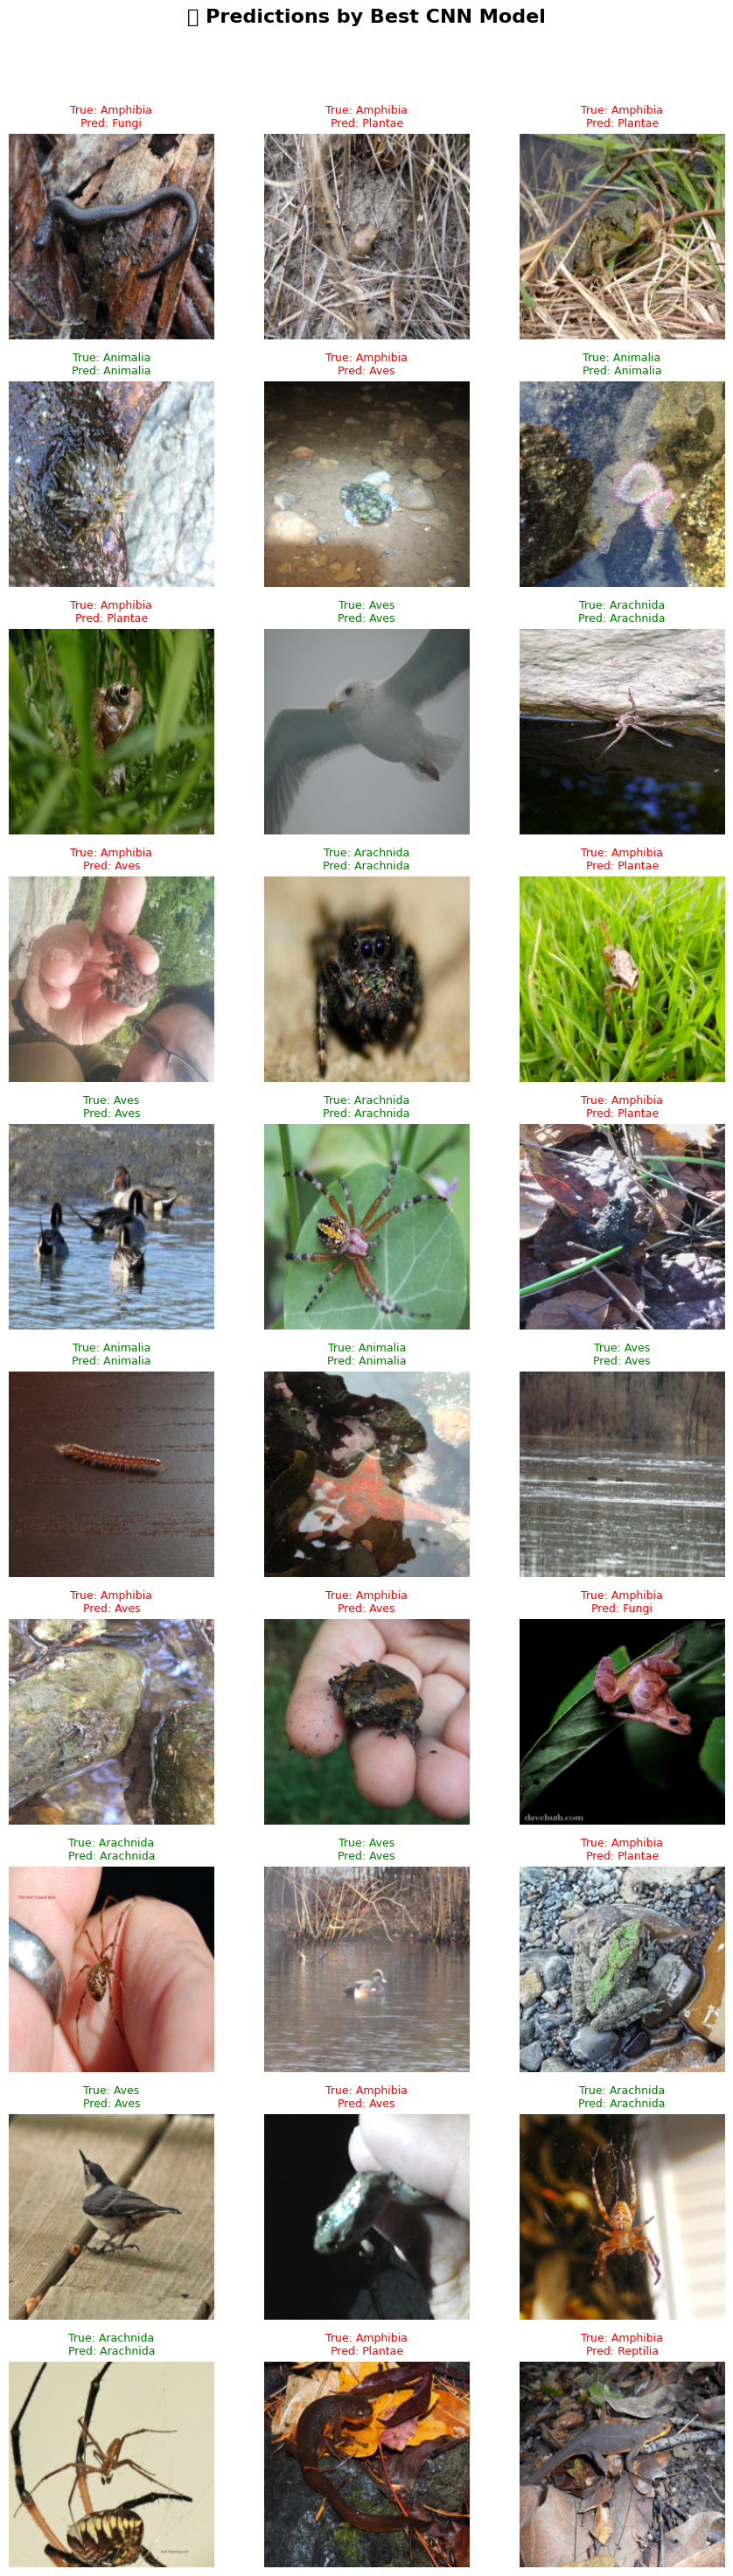

In [28]:
class_names = test_loader.dataset.classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🚀 Using device: {device}")

show_predictions_grid(model, test_loader, class_names, device)